# Part 2.1 - Feature Engineering for XGBoost Model
In this notebook, we will be loading the original train and test dataset so that we can engineer features based on the statistical properties of the flux and observation times.

This notebook is broken down into four parts
1. Compute the flux skewness for each `object_id`
2. Compute other statistical features
3. Merge features from Parts 1 and 2
4. Merge bottleneck features

In [60]:
import cudf as gd
import pandas as pd
import numpy as np
import math
import seaborn as sns
from termcolor import colored
from cudf_agg import cudf_groupby_aggs, compute_skew
import matplotlib.pyplot as plt
import warnings

from numba import cuda,jit,float32

from utils import scatter, groupby_aggs

In [61]:
warnings.filterwarnings("ignore")
sns.set()
print(gd.__version__)

0.8.0+0.g8fa7bd3.dirty


In [32]:
PATH = '/raid/cjnolet/plasticc_data/'

In [37]:
ts_cols = ['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected']
ts_dtypes = ['int32', 'float32', 'int32', 'float32','float32','int32']

### Part 1 - Compute Flux Skewness for each `object_id`

Load the training and test datasets back into cuDF DataFrames.

In [38]:
train_gd = gd.read_csv('%s/training_set.csv'%PATH, names=ts_cols,dtype=ts_dtypes,skiprows=1)
test_gd = gd.read_csv('%s/test_set_sample.csv'%PATH, names=ts_cols,dtype=ts_dtypes,skiprows=1)

In [39]:
test_gd.head().to_pandas()

,object_id,mjd,passband,flux,flux_err,detected
0,13,59798.320312,2,-1.299735,1.357315,0
1,13,59798.328125,1,-2.095392,1.148654,0
2,13,59798.335938,3,-0.923794,1.763655,0
3,13,59798.347656,4,-4.009815,2.602911,0
4,13,59798.359375,5,-3.403503,5.367328,0


Let's visualize the flux for different passbands at different times for a few different objects in our data set.

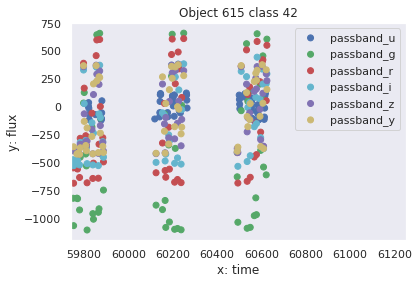

In [40]:
for idx, oid in zip(range(1), train_gd.object_id.unique()[:1]):
    train = train_gd.to_pandas()
    mask = train.object_id== oid

    scatter(train.loc[mask,'mjd'].values,
            train.loc[mask,'flux'].values,
            values=train.loc[mask,'passband'].values,
            xlabel='time',
            ylabel='flux',
            title='Object %d class 42'%oid)
    plt.show()

Since we are going to be computing the skewness of the `flux` for each `object_id`, we can safely drop all the other columns. 

In [41]:
test_gd = test_gd[['object_id','flux']]
train_gd = train_gd[['object_id','flux']]

The computation of the flux skewness is done using the `groupby() - apply_grouped()` techinque we used in the RNN feature engineering stage.

In [42]:
test_gd = cudf_groupby_aggs(test_gd,group_id_col='object_id',aggs={'flux': ["skew"]})
train_gd = cudf_groupby_aggs(train_gd,group_id_col='object_id',aggs={'flux':["skew"]})

In [43]:
test_flux_skew_gd = test_gd.sort_values(by='object_id')
train_flux_skew_gd = train_gd.sort_values(by='object_id')

In [44]:
train_flux_skew_gd.head().to_pandas()

,object_id,skew_flux
0,615,-0.349541
1,713,0.014989
2,730,3.177856
3,745,4.979831
4,1124,4.406288


### Part 2 - Compute Statistical Summary Features

We computed the flux skew in the previous ETL step and only kept those columns on GPU. Next we will need to load our original train & test CSV files back in so that we can do some additional aggregations.

In [45]:
train_gd = gd.read_csv('%s/training_set.csv'%PATH, names=ts_cols,dtype=ts_dtypes,skiprows=1)
test_gd = gd.read_csv('%s/test_set_sample.csv'%PATH, names=ts_cols,dtype=ts_dtypes,skiprows=1)

Read in the training metadata fields

In [46]:
cols = ['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf',
       'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 
       'distmod','mwebv', 'target']

dtypes = ['int32']+['float32']*4+['int32']+['float32']*5+['int32']

train_meta_gd = gd.read_csv('%s/training_set_metadata.csv'%PATH, names=cols, dtype=dtypes, skiprows=1)

In [47]:
train_meta_gd.head().to_pandas()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046082,-61.943840,320.796539,-51.753708,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085941,-27.784407,223.525528,-54.460751,1,1.8181,1.6267,0.2552,45.406303,0.007,88
2,730,33.574219,-6.579593,170.455582,-61.548218,1,0.2320,0.2262,0.0157,40.256100,0.021,42
3,745,0.189873,-45.586655,328.254456,-68.969299,1,0.3037,0.2813,1.1523,40.795101,0.007,90
4,1124,352.711304,-63.823654,316.922302,-51.059402,1,0.1934,0.2415,0.0176,40.416599,0.024,90


And the resulting testing metadata fields, excluding the `target` label field

In [48]:
# # Remove the target field from the cols 
del cols[-1],dtypes[-1]

test_meta_gd = gd.read_csv('%s/test_set_metadata.csv'%PATH, names=cols,dtype=dtypes,skiprows=1)

The remaining statistical summaries perform more `group_by()` and `apply_grouped()` computations.

In [49]:
def compute_statistical_features(df,df_meta):
    
    aggs = {
        'passband': ['mean'],  # mean passband
        'detected': ['mean'],  # mean detected
        'mjd':['max','min'],   # min / max time range
    }
    
    agg_df = groupby_aggs(df, aggs)
    
    # If flux uncertanty is low, we get a high ratio squared. If the uncertainty is high, 
    # we will get a low ratio squared.
    df['flux_ratio_sq'] = df['flux'] / df['flux_err']
    df['flux_ratio_sq'] = df['flux_ratio_sq'].applymap(lambda x: math.pow(x,2))
    
    # Multiply flux by the ratio squared
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    
    aggs2 = {
        'flux_ratio_sq':['sum'],            # Sum the sq flux ratios
        'flux_by_flux_ratio_sq':['sum'],    # Sum the flux * sq flux ratios
        'flux': ['min', 'max', 'mean'],     # Summary stats for flux
        'flux_err': ['min', 'max', 'mean'], # Summary stats for flux certainty
    }
    
    agg_df2 = groupby_aggs(df, aggs2)
    agg_df = agg_df.merge(agg_df2,on=['object_id'],how='left')
    del agg_df2

    agg_df['flux_diff'] = agg_df['max_flux'] - agg_df['min_flux']
    agg_df['flux_dif2'] = (agg_df['max_flux'] - agg_df['min_flux']) / agg_df['mean_flux']
    
    agg_df['flux_w_mean'] = agg_df['sum_flux_by_flux_ratio_sq'] / agg_df['sum_flux_ratio_sq']
    agg_df['flux_dif3'] = (agg_df['max_flux'] - agg_df['min_flux']) / agg_df['flux_w_mean']
    
    agg_df['mjd_diff'] = agg_df['max_mjd'] - agg_df['min_mjd']
    agg_df.drop_column('max_mjd')
    agg_df.drop_column('min_mjd')
    
    for col in ['ra','decl','gal_l','gal_b']:
        df_meta.drop_column(col)
    
    df_meta = df_meta.merge(agg_df,on=['object_id'],how='left')
    return df_meta

In [50]:
train_final_gd = compute_statistical_features(train_gd,train_meta_gd)
test_final_gd = compute_statistical_features(test_gd,test_meta_gd)

In [51]:
del train_gd,train_meta_gd
del test_gd,test_meta_gd

### Part 3 - Merge Flux Skew & Statistical Summaries

We use cuDF's `merge()` to combine the flux skew and statistical summary Dataframes by `object_id`

In [52]:
train_final_gd = train_final_gd.merge(train_flux_skew_gd,on=['object_id'],how='left')
test_final_gd = test_final_gd.merge(test_flux_skew_gd,on=['object_id'],how='left')

In [53]:
train_final_gd.head().to_pandas()

,object_id,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,mean_passband,mean_detected,...,mean_flux,min_flux_err,max_flux_err,mean_flux_err,flux_diff,flux_dif2,flux_w_mean,flux_dif3,mjd_diff,skew_flux
0,102036,1,0.2331,0.2269,0.0197,40.263500,0.009,42,2.400000,0.065714,...,1.244875,0.469055,9.096581,2.213910,46.388195,37.263342,15.754635,2.944416,848.820312,3.008304
1,102330,1,0.0000,0.0000,0.0000,NaN,0.028,16,2.647059,0.713725,...,39.777528,1.584902,63.237400,3.472844,262.050964,6.587915,34.394379,7.619006,854.652344,-1.944740
2,102343,1,0.1081,0.1422,0.0164,39.139397,0.013,67,2.400000,0.145714,...,28.677307,0.476192,9.142436,2.283224,661.231384,23.057652,318.312805,2.077301,848.820312,4.120196
3,102363,1,0.8046,0.7835,0.0167,43.447002,0.020,90,2.457386,0.022727,...,0.952557,0.675273,11.333863,2.727480,40.410751,42.423468,9.980136,4.049119,873.792969,2.215801
4,102745,1,0.2460,0.2333,1.0359,40.331497,0.018,90,2.457386,0.008523,...,0.966352,0.671322,11.307848,2.716346,29.274839,30.294180,5.194317,5.635936,873.792969,0.305252


### Part 4 - Merge in Bottleneck Features

Load the bottleneck features extracted from the RNN in `Part 1.2` and concatenate with the statistical features. 

At this point, the notebook from `Part 1.2` should have been executed end-to-end. You can also save time by using a set of features that have already been extracted. 

In [54]:
train_bn_file = "train_bn.pkl"  # Use `train_bn_saved.pkl` for pre-extracted features
test_bn_file = "test_bn.pkl"    # Use `test_bn_saved.pkl` for pre-extracted features

In [55]:
train_bn = gd.from_pandas(pd.read_pickle(train_bn_file))
test_bn = gd.from_pandas(pd.read_pickle(test_bn_file))

In [56]:
train_final_gd = train_final_gd.merge(train_bn,on=['object_id'],how='left')
test_final_gd = test_final_gd.merge(test_bn,on=['object_id'],how='left')

In [57]:
train_final_gd.head().to_pandas()

,object_id,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,mean_passband,mean_detected,...,bottleneck6,bottleneck7,bottleneck8,bottleneck9,bottleneck10,bottleneck11,bottleneck12,bottleneck13,bottleneck14,bottleneck15
0,191287,1,0.0000,0.0000,0.0000,NaN,0.021,65,2.336364,0.009091,...,6.283429,4.718782,1.619317,3.202919,5.222532,1.556044,4.114704,5.098020,0.048073,22.705059
1,191334,1,0.7632,0.7703,0.0329,43.401703,0.018,88,2.457386,0.514205,...,6.650832,10.496398,5.117399,2.728088,11.196789,0.556514,5.458009,2.808542,4.856879,14.684568
2,191397,1,0.3497,0.3083,0.0328,41.024101,0.023,90,2.336364,0.172727,...,20.268698,5.112232,3.696377,14.837788,1.480759,0.629527,3.716055,0.774229,16.195549,5.821880
3,191667,1,0.1447,0.1576,0.0135,39.383701,0.023,42,2.457386,0.224432,...,22.291304,9.205591,2.537441,1.873690,6.381655,9.245475,12.489989,0.447020,20.799400,14.036156
4,191847,1,0.0000,0.0000,0.0000,NaN,0.009,65,2.400000,0.017143,...,6.598294,5.393848,4.306551,1.066992,6.304627,1.928597,0.974238,2.365771,2.735358,10.880499


In [58]:
del train_bn,test_bn  # Save device? memory

### Store Final Train/Test Data to Disk

Store our extracted data out to csv files so that we can use it downstream 

In [59]:
train_final_gd.to_pandas().to_pickle("train_gdf.pkl")
test_final_gd.to_pandas().to_pickle("test_gdf.pkl")